Solvers: The Inverse Problem
============================


Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

For the sake of a simple crude example, we'll just use the synthetic light curve of a default binary with a bit of noise as our "observations".   See the [inverse problem example scripts](../examples.md) for more realistic examples.

In [3]:
b = phoebe.default_binary()
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))
b.run_compute(irrad_method='none')

times = b.get_value('times', context='model')
fluxes = b.get_value('fluxes', context='model') + np.random.normal(size=times.shape) * 0.01
sigmas = np.ones_like(times) * 0.02

b = phoebe.default_binary()
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=np.full_like(fluxes, fill_value=0.1))

<ParameterSet: 42 parameters | contexts: compute, constraint, figure, dataset>

Available Solvers
----------------------------------

PHOEBE includes wrappers around several different inverse-problem "algorithms" with a common interface.  These available "algorithms" are divided into three categories:

* estimators: provides proposed values for a number of parameters from the datasets as input alone, not requiring full forward-models via [run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md).
* optimizers: runs off-the-shelf optimizers to attempt to find the local (or global) solution.
* samplers: samples the local parameter space to estimate uncertainties and correlations.

To see the currently implemented set of solvers, we can call [phoebe.list_available_solvers](../api/phoebe.list_available_solvers.md)

In [4]:
print(phoebe.list_available_solvers())

['estimator.ebai', 'estimator.lc_geometry', 'estimator.lc_periodogram', 'estimator.rv_geometry', 'estimator.rv_periodogram', 'optimizer.cg', 'optimizer.differential_evolution', 'optimizer.nelder_mead', 'optimizer.powell', 'sampler.dynesty', 'sampler.emcee']


As there are quite a few and each have their own available options, we won't get in to the details here.  See the [solver API docs](../api/phoebe.parameters.solver.md) for details or look through some of the [solver example scripts](../examples.md).

As you may expect, to use a solver you must first call [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md), set the desired options, and then call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md) and [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)).

In [5]:
b.add_solver('estimator.lc_geometry', solver='my_lcgeom_solver')

<ParameterSet: 6 parameters | qualifiers: lc_combine, t0_near_times, comments, lc_datasets, expose_model, orbit>

In [6]:
print(b.get_solver(solver='my_lcgeom_solver'))

ParameterSet: 5 parameters
   comments@my_lcgeom_solver@s...: 
   lc_datasets@my_lcgeom_solve...: ['*']
    orbit@my_lcgeom_solver@solver: binary
   t0_near_times@my_lcgeom_sol...: True
   expose_model@my_lcgeom_solv...: True


In addition to the [solver API docs](../api/phoebe.parameters.solver.md), remember that each parameter has a description and possibly a set of available choices (if its a [ChoiceParameter](../api/phoebe.parameters.ChoiceParameter.md) or [SelectParameter](../api/phoebe.parameters.SelectParameter.md)).

In [7]:
print(b.get_parameter('expose_model').description)

Whether to expose the 2-gaussian analytical models in the solution


In [8]:
print(b.get_parameter('lc_datasets').description)

Light curve dataset(s) to use to extract eclipse geometry


In [9]:
print(b.get_parameter('lc_datasets').choices)

['lc01']


run_solver
---------------

[b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md) and [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)) allows optionally setting a `solution` tag (if not provided, one will be created automatically), just as [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) allows setting a `model` tag.  

In [10]:
b.run_solver(solver='my_lcgeom_solver', solution='my_lcgeom_solution')

/home/kyle/.local/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]


<ParameterSet: 22 parameters | qualifiers: input_fluxes, primary_phase, primary_width, fitted_values, comments, primary_depth, input_sigmas, analytic_best_model, secondary_phase, fitted_uniqueids, secondary_depth, input_phases, analytic_fluxes, analytic_phases, fitted_twigs, secondary_width, adopt_parameters, orbit, adopt_distributions, adopt_values, eclipse_edges, fitted_units>

In many cases, the `solution` itself is plottable - showing some sort of diagnostic figures.  In some cases, such as [sampler.emcee](../api/phoebe.parameters.solver.sampler.emcee.md) or [sampler.dynesty](../api/phoebe.parameters.solver.sampler.dynesty.md), there are several different diagnostic figures available which can be chosen by passing the available options to `style`.

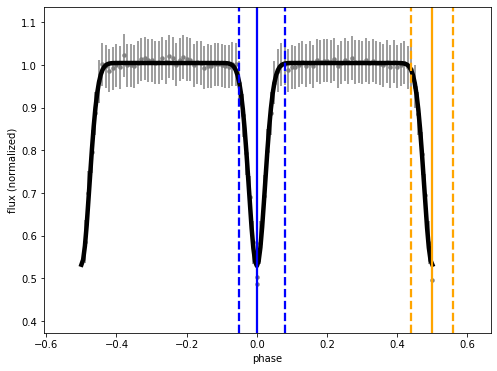

In [11]:
_ = b.plot(solution='my_lcgeom_solution', show=True)

The proposed values can be viewed via [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md).

By passing `trial_run=True` the proposed changed parameters will be shown, but not changed in the bundle itself.

In [12]:
print(b.adopt_solution(trial_run=True))

Wed, 03 Jun 2020 09:19 BUNDLE       WARNING solution='my_lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings


ParameterSet: 3 parameters
   t0_supconj@binary@orbit@com...: 0.999898616787037 d
       ecc@binary@orbit@component: 0.040000646178668324
      per0@binary@orbit@component: 90.32567244893173 deg


Otherwise, the changes will be made and all changed parameters (including those changed via [constraints](constraints.ipynb)) will be returned.

In [13]:
print(b.adopt_solution())

Wed, 03 Jun 2020 09:19 BUNDLE       WARNING solution='my_lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Wed, 03 Jun 2020 09:19 PARAMETERS   WARNING wrapping value of mean_anom to 359.7361357125983 deg


ParameterSet: 11 parameters
      t0_supconj@binary@component: 0.999898616787037 d
             ecc@binary@component: 0.040000646178668324
            per0@binary@component: 90.32567244893173 deg
C     t0_perpass@binary@component: 1.0007330052788792 d
C         t0_ref@binary@component: 0.9998283595874022 d
C     compute_phases@lc01@dataset: []
C          ecosw@binary@component: -0.00022736470928506674
C          esinw@binary@component: 0.03999999999999981
C    requiv_max@primary@component: 1.9462841259839871 solRad
C  requiv_max@secondary@component: 1.9462841259839871 solRad
C      mean_anom@binary@component: 359.7361357125983 deg


The Merit Function
-----------------

Both [optimizers](../api/phoebe.parameters.solver.optimizer.md) and [samplers](../api/phoebe.parameters.solver.sampler.md) require running a forward model and use a merit function to compare the synthetic model to the observational data.  This merit function is described in detail in the 2.3 release paper ([Conroy+ 2020](http://phoebe-project.org/publications/2020Conroy+)).

Several bundle methods allow for accessing the values used in the merit function:

* [b.calculate_residuals](../api/phoebe.parameters.ParameterSet.calculate_residuals.md)
* [b.calculate_chi2](../api/phoebe.parameters.ParameterSet.calculate_chi2.md)
* [b.calculate_lnlikelihood](../api/phoebe.parameters.ParameterSet.calculate_lnlikelihood.md)
* [b.calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md)

The log-probability used as the merit function within optimizers and samplers is defined as [calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md)`(priors, combine=priors_combine)` + [calculate_lnlikelihood](../api/phoebe.parameters.ParameterSet.calculate_lnlikelihood).

To see the affect of `priors_combine`, we can pass the `solver` tag directly to [b.get_distribution_collection](../api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md), [b.plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md), or [b.calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md).

In [14]:
b.add_distribution('teff@primary', phoebe.gaussian(6000,100), distribution='mydist01')
b.add_distribution('teff@secondary', phoebe.gaussian(5500,600), distribution='mydist01')

b.add_distribution('teff@primary', phoebe.uniform(5800,6200), distribution='mydist02')

<ParameterSet: 1 parameters>

In [15]:
b.add_solver('sampler.emcee', priors=['mydist01', 'mydist02'], solver='myemceesolver')

Wed, 03 Jun 2020 09:19 BUNDLE       WARNING no valid distributions in init_from  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


<ParameterSet: 13 parameters | qualifiers: thin_factor, init_from, init_from_combine, continue_from, nwalkers, niters, priors, comments, burnin_factor, expose_failed, compute, priors_combine, progress_every_niters>

In [16]:
print(b.filter(qualifier='prior*'))

ParameterSet: 2 parameters
      priors@myemceesolver@solver: ['mydist01', 'mydist02']
   priors_combine@myemceesolve...: and


Now we'll look at the affect of `priors_combine` on the resulting priors distributions that would be sent to the merit function.

In [17]:
print(b.get_parameter('priors_combine').description)

Method to use to combine multiple distributions from priors for the same parameter.  first: ignore duplicate entries and take the first in the priors parameter. and: combine duplicate entries via AND logic, dropping covariances.  or: combine duplicate entries via OR logic, dropping covariances.


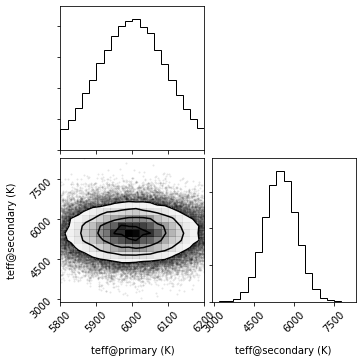

In [18]:
_ = b.plot_distribution_collection('priors@myemceesolver', show=True)

In [19]:
b.calculate_lnp('priors@myemceesolver')

-13.140649347269667

In [20]:
b.set_value('priors_combine', 'first')

Wed, 03 Jun 2020 09:19 BUNDLE       WARNING no valid distributions in init_from  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


Wed, 03 Jun 2020 09:19 BUNDLE       WARNING ignoring distribution on teff@primary@star@component with distribution='mydist02' as distribution existed on an earlier distribution which takes precedence.


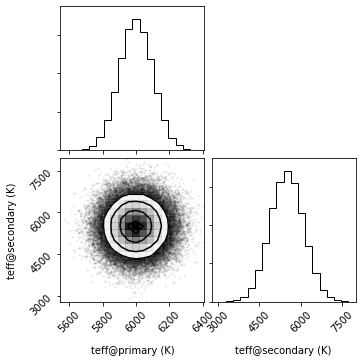

In [21]:
_ = b.plot_distribution_collection('priors@myemceesolver', show=True)

In [22]:
b.calculate_lnp('priors@myemceesolver')

Wed, 03 Jun 2020 09:19 BUNDLE       WARNING ignoring distribution on teff@primary@star@component with distribution='mydist02' as distribution existed on an earlier distribution which takes precedence.


-13.187199129835806

As with the example above, to run an `emcee` run, just set all the desired options in the `solver` parameters, and then call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md).  This will then expose the resulting chains in the solution, which are available for plotting and adopting.  See the  [solver example scripts](../examples.md) or the individual [API docs for solvers](../api/phoebe.parameters.solver.md) for more details on each available algorithm.

Next
----------

That's it!! You've completed all the basic tutorials.  Now give PHOEBE a try or dig into some of the [advanced tutorials](../tutorials.md) and [example scripts](../examples.md).